<span style="font-size: 14pt">YEREVAN, May-June 2017</span>

<span style="font-size: 16pt"> HW #5: Compositions of time series forecasting algorithms

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>


<h1 align="center"> Home Work 5 </h1>
** Realize following composions for adaptive algorithms (ESM): Adaptive Selection and Adaptive Composition.**

Start with the code below

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime, timedelta
from utils import qualityRMSE, qualityMedianAE, qualityMACAPE
from utils import SimpleExponentialSmoothing, AdaptiveExponentialSmoothing # , TheilWageExponentialSmoothing

In [2]:
def AdaptiveSelection(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    BaseAlgs = Params['BaseAlgsParams']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    for ba in range(len(BaseAlgs)):
        FORECAST_BA[ba]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
    
    # internal params of composition
    gamma = Params['gamma']
    eps = Params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    e1 = np.zeros(N)  # initialization of errors of base algorithms 
    j_best = np.zeros(N)
    
    y = 0.5
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                ee = np.abs(x[t]-FORECAST_BA.transpose()[t])
                
                if not np.any(np.isnan(ee)):
                    e1 = gamma * ee + (1- gamma) * e1
                
                if not np.all(np.isnan(e1)): 
                    # select best algorithm at the moment t
                    j_best = np.nanargmin(e1)   #find index of best base alg'
                    
                    # select best indistinctive 
                    idx_bestinsdistinctive = np.where(e1 < e1[j_best] + eps)[-1] #find indexes of best indistinctive algorithms'
            
                    y = FORECAST_BA[idx_bestinsdistinctive,t].mean()
                
                # else do nothing
            #else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [3]:
def AdaptiveCombination(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    # Base Algs Forecasts     
    BaseAlgs = Params['BaseAlgsParams']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
     
    
    #     forecast TS by each base algs
    #     be careful with eval() function    
    #for ba in range(len(BaseAlgs)):
        #FORECAST_BA[BA]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
    for ba in range(N):
        FORECAST_BA[ba]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
        
    # internal params of composition
    gamma = Params['gamma']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.zeros(N)  # initialization of errors of base algorithms 
    weights = np.zeros(N) 
    y = 0.5
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            
            if t>= h:
                
                ee = np.abs(x[t]-FORECAST_BA.transpose()[t])
                
                if not np.any(np.isnan(ee)):
                    e1 = gamma * ee + (1- gamma) * e1
                
                if not np.all(np.isnan(e1)): 
                    # select best algorithm at the moment t
                    w_best = (1/e1) / (np.sum(1/e1)) #calculate weights of base algorithms
                
                    #Calculate forecast of the composition
                    y = np.dot(w_best,FORECAST_BA.T[t])
                    #y = np.dot(FORECAST_BA.T[t], w_best)
                # else do nothing
        #else do nothing
            
            
        FORECAST[t+h] = y
    return FORECAST

In [4]:
BaseAlgs = [{'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.2,'gamma':0.01, 'AdaptationPeriod':10}}
#                  {'BaseAlg':'AdaptiveSimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1, 'gamma':0.01}},
#                 {'BaseAlg':'TheilWageSmoothing', 'BaseAlgParams':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [5]:
for ba in range(len(BaseAlgs)):
    print(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgsParams'])")

SimpleExponentialSmoothing(x,h,BaseAlgs[0]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[1]['BaseAlgsParams'])


In [6]:
ts = pd.read_csv('./data/TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index

In [7]:
h =1 
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+timedelta(1), ts.index[-1]+timedelta(h)))
                      , columns = ts.columns)
FRC_TS = dict()

In [8]:
# run Adaptive Selection
gamma=0.01
eps = 1.0

for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveSelection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'BaseAlgsParams':BaseAlgs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

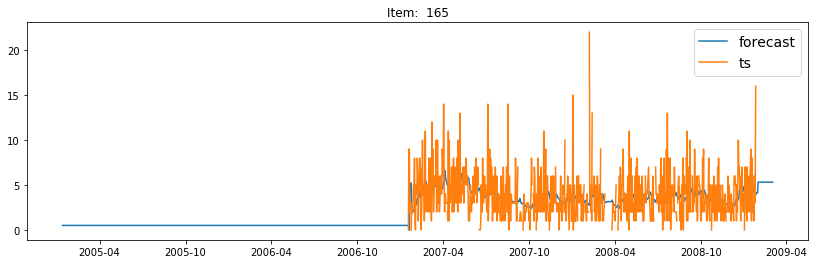

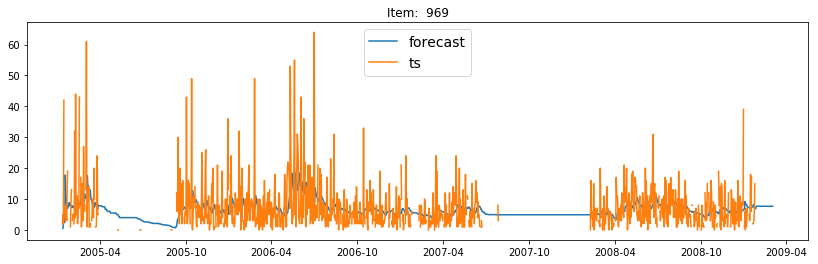

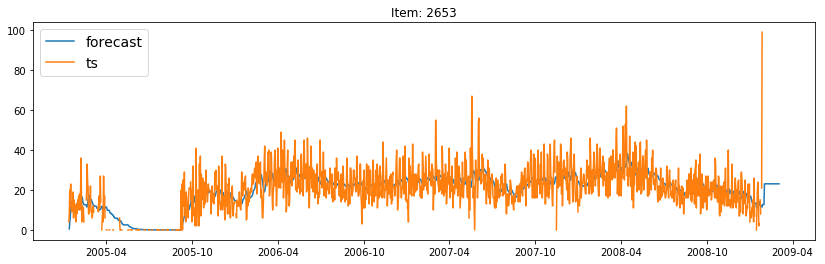

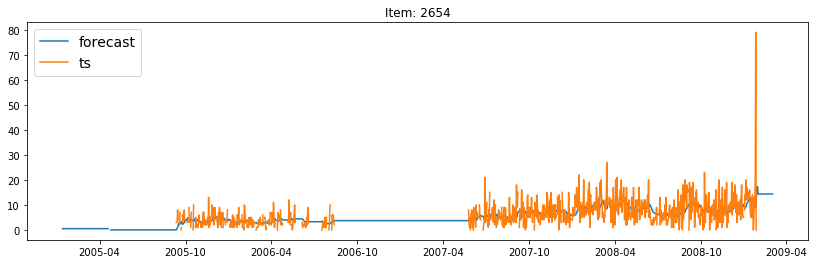

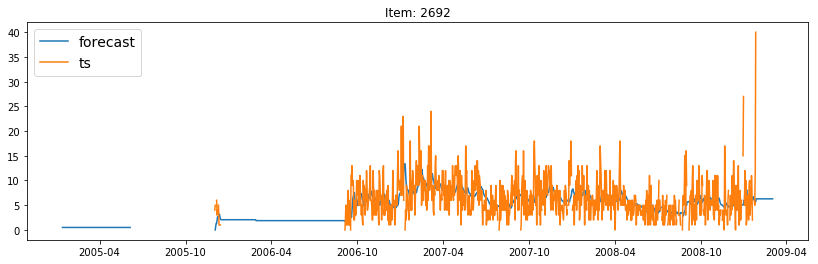

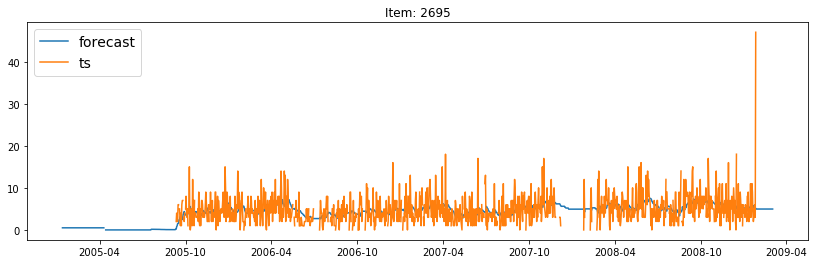

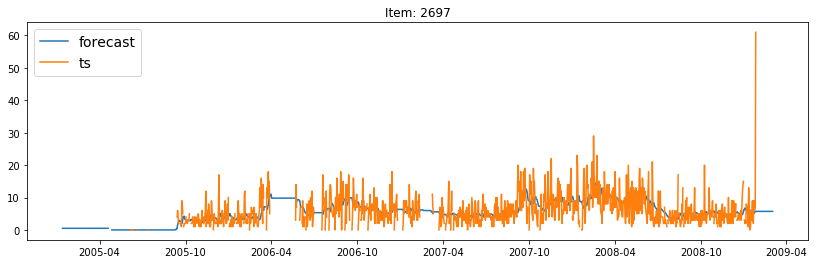

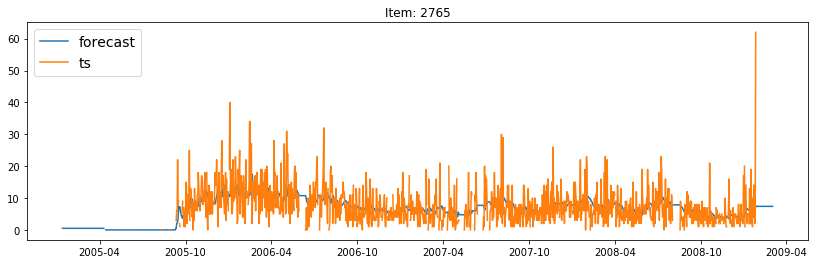

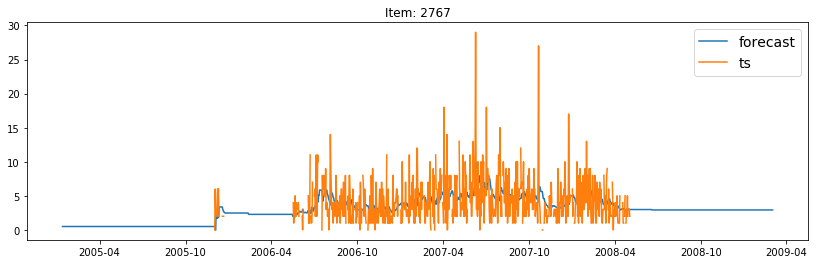

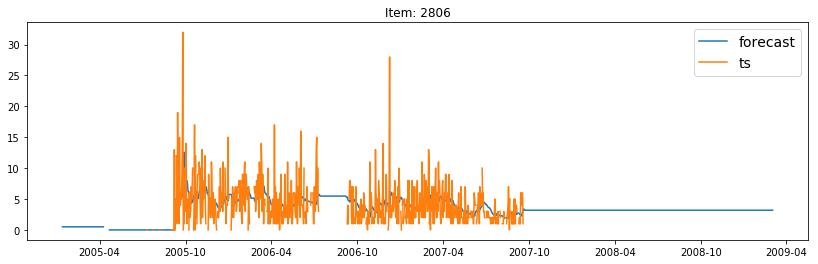

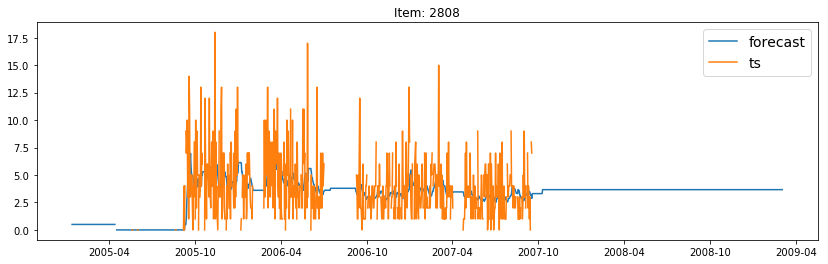

In [9]:
for cntr in frc_ts.columns:
    plt.figure(figsize=(14,4))
    plt.plot(frc_ts[cntr], label="forecast")
    plt.plot(ts[cntr], label ="ts")
    plt.legend(fontsize =14)
    plt.title(cntr)
    plt.show()

In [10]:
# run Adaptive Composition
gamma=0.01

for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveCombination(ts[cntr],h, {'gamma':gamma, 'BaseAlgsParams':BaseAlgs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

/home/gasia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: divide by zero encountered in true_divide
/home/gasia/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:60: RuntimeWarning: invalid value encountered in true_divide


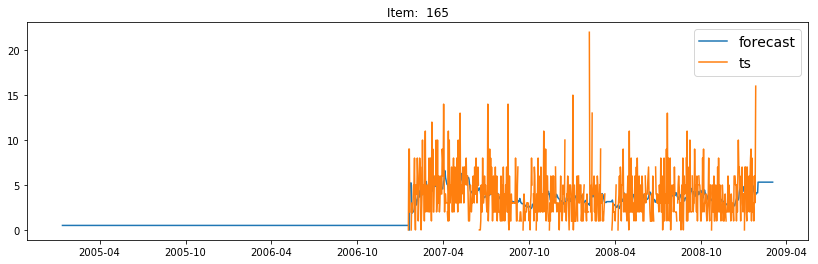

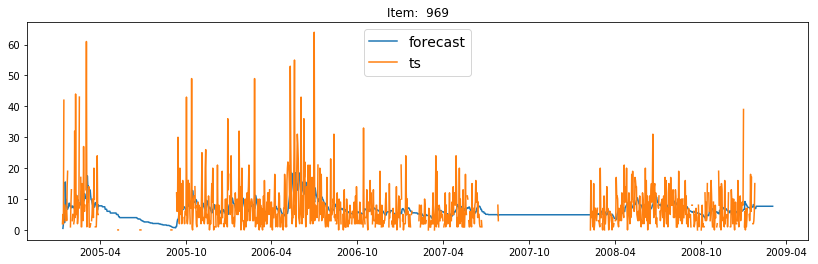

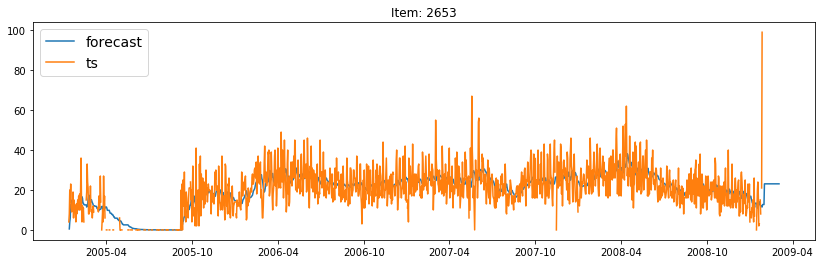

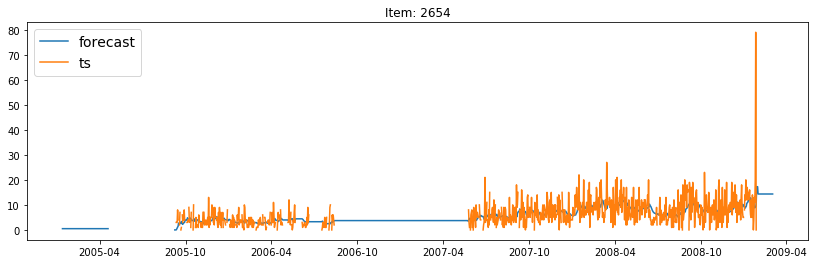

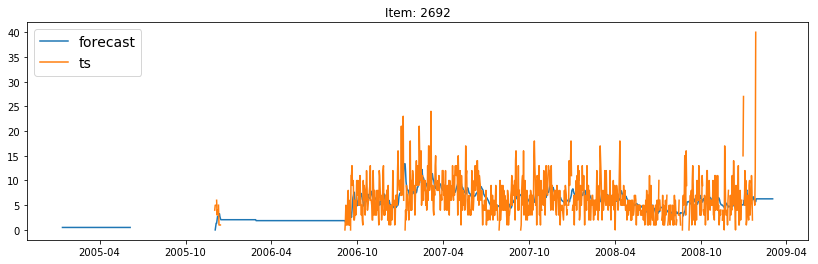

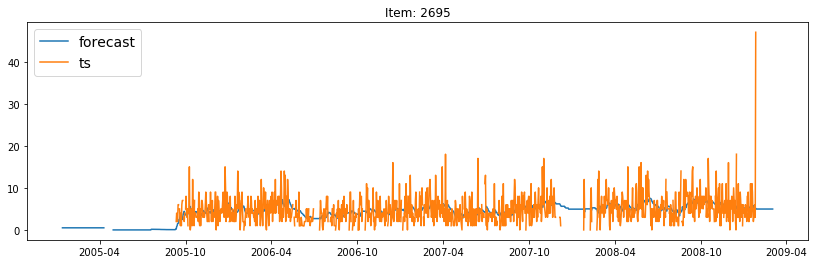

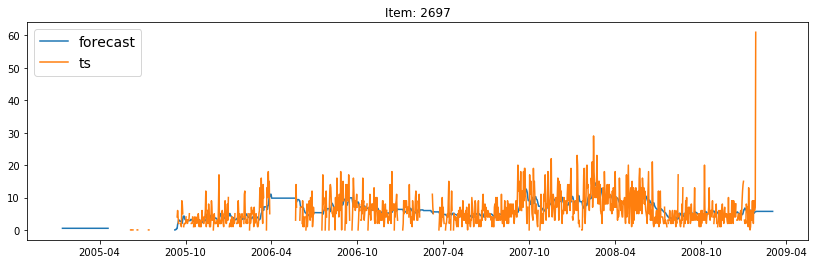

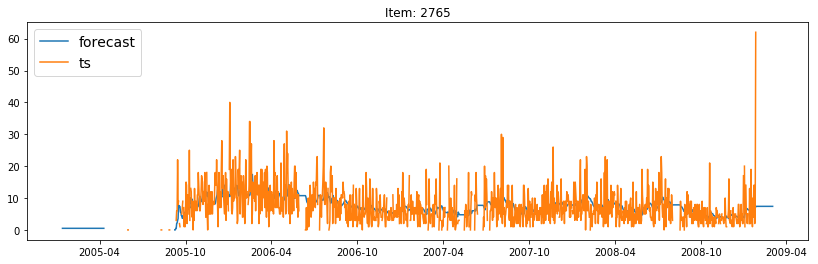

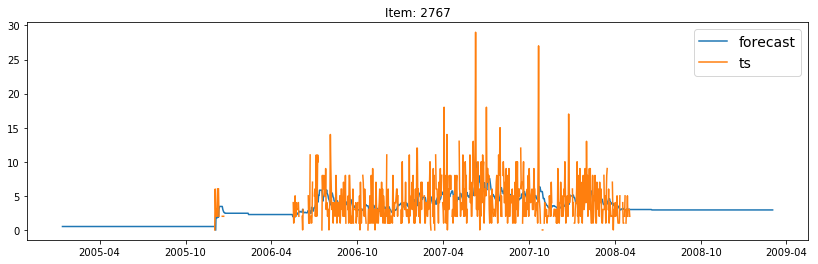

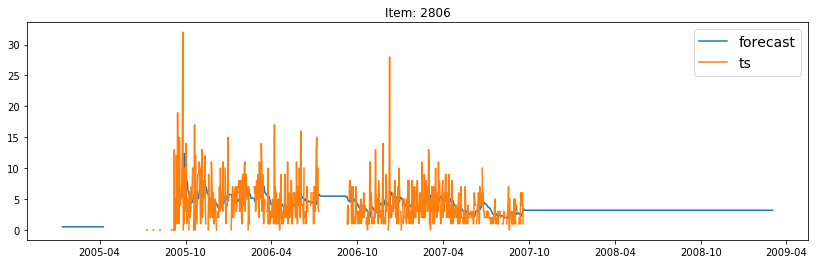

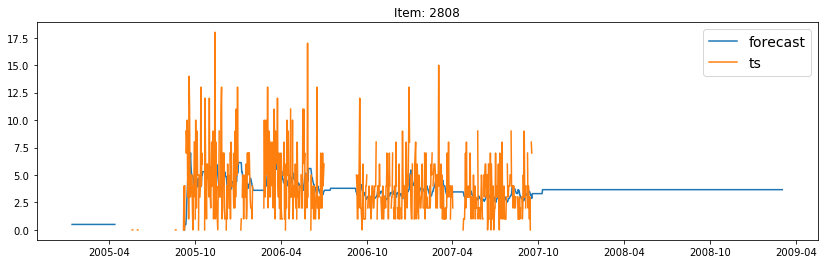

In [11]:
for cntr in frc_ts.columns:
    plt.figure(figsize=(14,4))
    plt.plot(frc_ts[cntr], label="forecast")
    plt.plot(ts[cntr], label ="ts")
    plt.legend(fontsize =14)
    plt.title(cntr)
    plt.show()

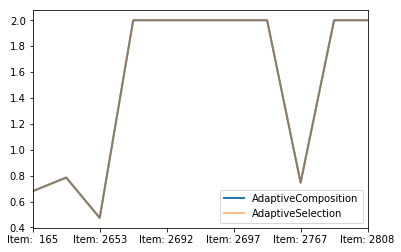

In [12]:
# plot loss of compositions
ix = range(100)
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+timedelta(50))
        QualityStr[model][ts_num],_ = qualityMACAPE(ts[ts_num].loc[ix], frc_ts[ts_num].loc[ix])

QualityStr[sorted(QualityStr.columns)[0]].plot(label='AdaptiveComposition', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[1]].plot(label='AdaptiveSelection', linewidth=2.0, alpha=0.5)

plt.legend()

In [13]:
QualityStr

,AC gamma 0.01,AS gamma 0.01 eps 1.00
Item: 165,0.680478,0.680478
Item: 969,0.785224,0.785224
Item: 2653,0.47355,0.47355
Item: 2654,2,2
Item: 2692,2,2
Item: 2695,2,2
Item: 2697,2,2
Item: 2765,2,2
Item: 2767,0.745545,0.745545
Item: 2806,2,2
